# Day 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 붓꽃 데이터

다중 유형 분류

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
print(iris.data.shape)
# 유형 도수
pd.Series(iris.target).value_counts()

(150, 4)


0    50
1    50
2    50
Name: count, dtype: int64

In [50]:
from sklearn.linear_model import Perceptron

scores = {}

model = Perceptron(max_iter=20, eta0=0.1, shuffle=False)
model.fit(iris.data, iris.target)
scores['unshuffled'] = model.score(iris.data, iris.target)

model = Perceptron(max_iter=20, eta0=0.1, shuffle=True, random_state=3)
model.fit(iris.data, iris.target)
scores['shuffled'] = model.score(iris.data, iris.target)

print(pd.Series(scores).round(3))
pd.DataFrame(model.coef_, columns=iris.feature_names, index=iris.target_names).assign(
    bias=model.intercept_)

W = model.coef_; b = model.intercept_
outputs = iris.data @ W.T + b # X @ W.T + b
예측 = np.argmax(outputs, axis=1)
assert np.all(예측 == model.predict(iris.data))
print(f'정확도: {(예측 == iris.target).mean():.1%}')
pd.DataFrame(outputs, columns=iris.target_names).assign(예측=예측, 정답=iris.target).sample(5, random_state=0)

unshuffled    0.667
shuffled      0.967
dtype: float64
정확도: 96.7%


,setosa,versicolor,virginica,예측,정답
114,-2.834,-1.110,7.958,2,2
62,-1.544,3.598,-2.578,1,1
33,2.053,-2.402,-23.596,0,0
107,-3.294,2.977,6.381,2,2
7,1.446,-0.812,-19.152,0,0


In [45]:
A = np.arange(1, 5).reshape(2, 2)
B = np.arange(5, 9).reshape(2, 2)
C = A * B # 원소별 곱셈
D = A @ B # 행렬 곱셈

# 행렬곱
results = []
for 행 in A:
    for 열 in B.T:
        results.append(np.sum(행 * 열))
results = np.array(results).reshape(2, 2)
assert np.all(results == D) and np.all(np.dot(A, B) == D)

frame = pd.concat([pd.DataFrame(A), pd.DataFrame(B), pd.DataFrame(C), pd.DataFrame(D)], axis=1)
frame.columns = pd.MultiIndex.from_product([['A', 'B', 'C', 'D'], [0, 1]])
frame

A     B      C       D    
   0  1  0  1   0   1   0   1
0  1  2  5  6   5  12  19  22
1  3  4  7  8  21  32  43  50

## 신경망 순전파

In [57]:
random = np.random.default_rng(3)

xi = np.array([0.1, 0.2])

# layer 1
W1 = random.normal(size=(2, 3)) # 입력 2, 출력 3
b1 = random.normal(size=3) # 출력 3
# layer 2
W2 = random.normal(size=(3, 2)) # 입력 3, 출력 2
b2 = random.normal(size=2) # 출력 2
# layer 3
W3 = random.normal(size=(2, 1)) # 입력 2, 출력 1
b3 = random.normal(size=1) # 출력 1

# 순전파 (feed-forward)
z1 = xi @ W1 + b1
z2 = z1 @ W2 + b2
z3 = z2 @ W3 + b3

print(f'z1={z1.round(3)}')
print(f'z2={z2.round(3)}')
print(f'z3={z3.round(3)}')

z1=[-1.929 -0.578 -0.867]
z2=[-6.02   1.123]
z3=[2.312]


In [73]:
class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화

    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
    
class 신경망:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        for layer in self.layers:
            x = layer(x)
        return x
    
layer1 = 다중퍼셉트론(2, 3)
layer2 = 다중퍼셉트론(3, 2)
layer3 = 다중퍼셉트론(2, 1)

# 순전파
outputs = layer3(layer2(layer1(xi)))
print(f'outputs={outputs.round(3)}')

model = 신경망()
model.add(layer1)
model.add(layer2)
model.add(layer3)

assert np.all(outputs == model(xi))

outputs=[0.305]


In [72]:
import torch
import torch.nn as nn # neural network

X = torch.tensor([[0.1, 0.2]])
print(X.shape)

layer1 = nn.Linear(2, 3) # 입력 2, 출력 3
assert torch.allclose(layer1(X), X @ layer1.weight.T + layer1.bias)
layer2 = nn.Linear(3, 2) # 입력 3, 출력 2
layer3 = nn.Linear(2, 1) # 입력 2, 출력 1

outputs = layer3(layer2(layer1(X)))

model = nn.Sequential(layer1, layer2, layer3)
assert torch.allclose(outputs, model(X))

torch.Size([1, 2])


## 활성화

* 은닉층: 비선형 변환
* 출력층
    1. 회귀: 항등함수 (활성화 없음)
    1. 분류
        1. 이진 분류: sigmoid
        1. 다중 분류: softmax

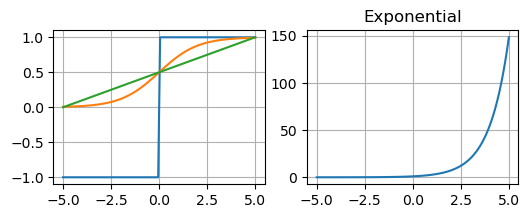

In [154]:
step = lambda x: np.where(x > 0, 1, -1)
sigmoid = lambda x: 1 / (1 + np.exp(-x))
minmax = lambda x: (x - x.min()) / (x.max() - x.min())

xs = np.linspace(-5, 5, 100)

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(xs, step(xs))
plt.plot(xs, sigmoid(xs))
plt.plot(xs, minmax(xs))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(xs, np.exp(xs))
plt.title('Exponential')
plt.grid()
plt.show()

## 로지스틱 시그모이드

분류를 위한 확률 모델링 과정에서 개발 (1958)

In [118]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
print(cancer.data.shape)
display(pd.DataFrame(cancer.data, columns=cancer.feature_names).head().round(2))
print(pd.Series(cancer.target).value_counts().rename({0: '악성', 1: '양성'}))

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.12,0.28,0.30,0.15,0.24,0.08,...,25.38,17.33,184.60,2019.0,0.16,0.67,0.71,0.27,0.46,0.12
1,20.57,17.77,132.90,1326.0,0.08,0.08,0.09,0.07,0.18,0.06,...,24.99,23.41,158.80,1956.0,0.12,0.19,0.24,0.19,0.28,0.09
2,19.69,21.25,130.00,1203.0,0.11,0.16,0.20,0.13,0.21,0.06,...,23.57,25.53,152.50,1709.0,0.14,0.42,0.45,0.24,0.36,0.09
3,11.42,20.38,77.58,386.1,0.14,0.28,0.24,0.11,0.26,0.10,...,14.91,26.50,98.87,567.7,0.21,0.87,0.69,0.26,0.66,0.17
4,20.29,14.34,135.10,1297.0,0.10,0.13,0.20,0.10,0.18,0.06,...,22.54,16.67,152.20,1575.0,0.14,0.20,0.40,0.16,0.24,0.08


양성    357
악성    212
Name: count, dtype: int64


In [127]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.preprocessing import StandardScaler

scores = {}
model_1 = Perceptron(max_iter=100, eta0=0.1, shuffle=True, random_state=3)
model_1.fit(cancer.data, cancer.target)
scores['Perceptron'] = model_1.score(cancer.data, cancer.target)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cancer.data)
# 데이터를 특성별로 표준화: 평균 0, 표준편차 1
assert np.allclose(scaled_data.mean(axis=0), 0) and np.allclose(scaled_data.std(axis=0), 1)
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(scaled_data, cancer.target)
scores['LogisticRegression'] = model_2.score(scaled_data, cancer.target)

print(pd.Series(scores).round(3))

예측확률 = model_2.predict_proba(scaled_data)
display(pd.DataFrame(cancer.data).assign(
    예측1=model_1.predict(cancer.data),
    예측2=model_2.predict(scaled_data),
    예측확률=예측확률[:, 1]
).sample(5, random_state=4).round(3))


Perceptron            0.912
LogisticRegression    0.988
dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,예측1,예측2,예측확률
340,14.42,16.54,94.15,641.2,0.098,0.114,0.080,0.042,0.191,0.064,...,862.1,0.129,0.337,0.376,0.141,0.305,0.088,0,1,0.755
382,12.05,22.72,78.75,447.8,0.069,0.107,0.079,0.030,0.120,0.067,...,488.4,0.088,0.321,0.291,0.109,0.219,0.093,1,1,1.000
300,19.53,18.90,129.50,1217.0,0.115,0.164,0.220,0.106,0.179,0.066,...,2053.0,0.150,0.412,0.612,0.198,0.297,0.099,0,0,0.000
262,17.29,22.13,114.40,947.8,0.090,0.127,0.097,0.075,0.211,0.055,...,1295.0,0.113,0.287,0.230,0.153,0.307,0.075,0,0,0.002
363,16.50,18.29,106.60,838.1,0.097,0.085,0.059,0.048,0.150,0.056,...,1009.0,0.134,0.168,0.166,0.091,0.239,0.065,0,1,0.578


In [ ]:
W = model_2.coef_; b = model_2.intercept_
outputs = scaled_data @ W.T + b # X @ W.T + b
p1 = sigmoid(outputs) # Pr(y=1|x)
예측 = np.where(p1 > 0.5, 1, 0) # 임계값 0.5 (50%)
p0 = 1 - p1
예측확률 = np.hstack([p0, p1])
assert np.allclose(예측확률, model_2.predict_proba(scaled_data))
pd.DataFrame(예측확률, columns=['Pr(y=0|x)', 'Pr(y=1|x)']).assign(
    예측=예측, predict=model_2.predict(scaled_data)).sample(5, random_state=4).round(3)

,Pr(y=0|x),Pr(y=1|x),예측,predict
340,0.245,0.755,1,1
382,0.000,1.000,1,1
300,1.000,0.000,0,0
262,0.998,0.002,0,0
363,0.422,0.578,1,1


### 승산률

$$
\text{odd ratio} = \frac{p}{1 - p}, \quad p=Pr(y=1)
$$

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
승리확률,0.0,0.01,0.020,0.030,0.040,0.051,0.061,0.071,0.081,0.091,...,0.909,0.919,0.929,0.939,0.949,0.96,0.97,0.98,0.990,1.000
승산률,0.0,0.01,0.021,0.031,0.042,0.053,0.065,0.076,0.088,0.100,...,10.000,11.375,13.143,15.500,18.800,23.75,32.00,48.50,97.999,9999999.005


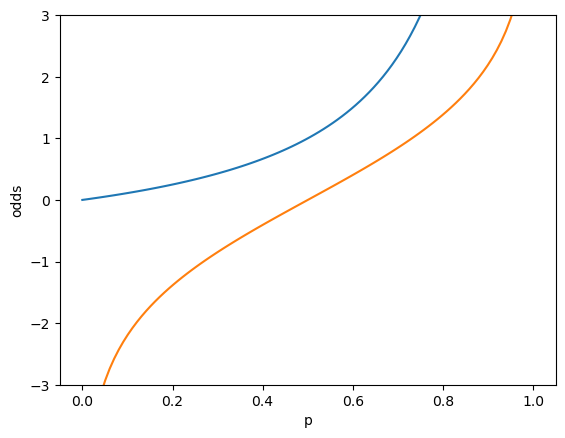

In [ ]:
승산률 = lambda 승리확률: 승리확률 / (1 - 승리확률)
승리확률 = np.linspace(0, 1.0 - 1e-7, 100)

display(pd.DataFrame({
    '승리확률': 승리확률,
    '승산률': 승산률(승리확률),
}).round(3).T)

plt.plot(승리확률, 승산률(승리확률)) # 승산률: odds > 0
plt.plot(승리확률, np.log(승산률(승리확률) + 1e-7)) # -inf < 로그 승산률 < inf
plt.xlabel('p'); plt.ylabel('odds')
plt.ylim(-3, 3)
plt.show()

## 은닉층 활성화

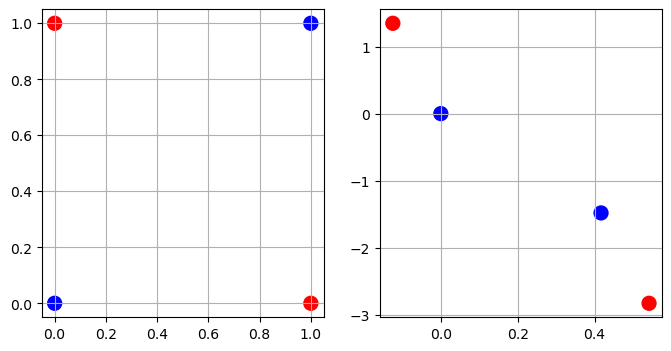

In [ ]:
Xs = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])
y_xor = np.array([0, 1, 1, 0])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(Xs[:, 0], Xs[:, 1], c=y_xor, s=100, cmap='bwr')
plt.grid()
plt.subplot(1, 2, 2)
for _ in range(3): # 여러 계층을 통과하는 효과
    Xs = 다중퍼셉트론(2, 2, 활성화=None, seed=1)(Xs)
plt.scatter(Xs[:, 0], Xs[:, 1], c=y_xor, s=100, cmap='bwr')
plt.grid()
plt.show()